# 3.1.1 Data Understanding, Analysis, Visualization and Cleaning


### What does the dataset represent?
This dataset contains MRI scans of brain tumors. It consists of four classes: Glioma Tumor, Meningioma Tumor, Pituitary Tumor, and No Tumor. The images are labeled to support supervised classification tasks.

### How many total images are in the dataset?
The dataset consists of several thousand labeled images, separated into class folders. The total number of images is computed during preprocessing.

### What is the distribution of images across different classes?
A count of image files is computed from each class folder, which helps to determine if the dataset is balanced or imbalanced.

### How is the dataset split into training and validation sets? Justify your choice.
The dataset is split using a standard 80/20 train-validation strategy using `train_test_split`. This ratio provides enough samples for training while retaining data for unbiased validation.

### What preprocessing techniques were applied?
- Image resizing to 80x80 pixels for baseline models, and 224x224 for transfer learning.
- Normalization (implicitly via `img_to_array` and potentially `ImageDataGenerator`).

### What data generators were used?
We used Keras `ImageDataGenerator` for rescaling and optional augmentation such as horizontal flip, zoom, and rotation.

### Visualizations of sample augmented images:
![Insert example here: use plt.imshow on augmented batches]


# 3.1.2 Design, Train, and Evaluate a Baseline Model


### Model Architecture
The baseline CNN includes:
- 3 Convolutional Layers + MaxPooling
- Flatten Layer
- 3 Fully Connected Layers (FCN)
- Final softmax output layer for classification

Activation: ReLU for hidden layers, softmax for output  
Kernel Size: 3x3

### Model Summary
Printed using `model.summary()`.

### Model Training
The model was trained for N epochs using categorical crossentropy loss and accuracy metric. Training and validation loss and accuracy curves are plotted.

### Model Evaluation
Evaluation was performed using:
- Accuracy
- Precision
- Recall
- F1-Score

Sample predictions were visualized with true vs predicted labels.


# 3.1.3 Deeper Architecture with Regularization


### Extended Model Design
- Double the number of convolutional layers compared to the baseline
- Increased filter sizes
- Dropout layers added for regularization

### Training Strategy
The deeper model was trained similarly, with early stopping or checkpointing optionally used.

### Evaluation
Metrics same as baseline, with plots showing comparison.


# 3.1.4 Comparative Analysis


### Baseline vs Deeper Model
| Model       | Accuracy | Precision | Recall | F1 Score |
|-------------|----------|-----------|--------|----------|
| Baseline    | 0.80     | 0.72      | 0.92   | 0.81     |
| Deeper      | 0.83     | 0.85      | 0.91   | 0.88     |


- More filters and layers led to improved learning capability but at higher computational cost.

### Optimizer Comparison (SGD vs Adam)
- SGD: slower convergence, more stable
- Adam: faster convergence, potentially better final performance

Trade-offs between training time and final accuracy discussed.


# 3.2 Transfer Learning with Pre-trained CNN


### Model Selection
The InceptionV3 pre-trained model was selected for transfer learning due to its proven effectiveness in capturing multi-scale features and its strong performance on complex image classification tasks.

### Model Adaptation
- The top fully connected layers of InceptionV3 were removed.
- A custom classification head was added, including dense layers tailored for 4-class tumor classification.
- Input images were resized to 224×224 to match the model’s expected input dimensions

### Fine-tuning Strategy
- Initially, all convolutional layers were frozen to use InceptionV3 as a feature extractor.
-In later stages, selective fine-tuning was performed by unfreezing the top layers and training with a lower learning rate to adapt the model more precisely to the tumor dataset.

### Evaluation
The model was evaluated using standard metrics such as accuracy, loss curves, confusion matrix, classification report, and F1-score. Visualization of training/validation performance across epochs was also performed.

### Comparative Discussion
The InceptionV3-based transfer learning model outperformed both baseline models (FCN and CNN) in terms of validation accuracy, generalization, and training efficiency.

In [46]:
zip_path = '/content/brain_tumour.zip'

In [47]:
import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/brain_tumor_datas')


In [49]:
import os
os.listdir('/content/brain_tumor_datas')


['Training', 'Testing']

In [50]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
# Change the import statement below
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import ImageDataGenerator from tensorflow.keras

In [52]:


# Define the base path
base_path = '/content/brain_tumor_datas/Training'


subdirs = [
    'glioma_tumor',
    'meningioma_tumor',
    'no_tumor',
    'pituitary_tumor'
]




In [53]:
import os
import numpy as np
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array

# Define the target image size
image_size = (80, 80)

# Initialize lists to store image data, class labels, class names, and corrupted images
image_data = []
class_labels = []
class_names = []
corrupted_images = []

# Iterate through each subdirectory (class) in the base path
for subdir in subdirs:
    # Construct the full path to the class directory
    full_class_path = os.path.join(base_path, subdir)

    # Extract the class name from the subdirectory path
    class_name = subdir.split("/")[-1]
    class_names.append(class_name)

    # Iterate through each file (image) in the class directory
    for filename in os.listdir(full_class_path):
        image_path = os.path.join(full_class_path, filename)

        try:
            # Load the image and resize it to the target size
            image = load_img(image_path, target_size=image_size)

            # Convert the image to a numerical array
            image_array = img_to_array(image)

            # Append the image array to the image data list
            image_data.append(image_array)

            # Append the class label to the class labels list
            class_labels.append(class_names.index(class_name))
        except Exception as e:
            # Handle any exceptions that occur during image loading
            print(f"Error loading image {image_path}: {e}")
            corrupted_images.append(image_path)

# Convert the image data and class labels lists to NumPy arrays
X_data = np.array(image_data)
y_labels = np.array(class_labels)

In [54]:
# Print the number of images in the dataset
print("Number of images:", len(X_data))

# Print the shape of the images in the dataset
print("Shape of images:", X_data.shape)

# Print the number of classes in the dataset
print("Number of classes:", len(class_names))

# Print the names of the classes in the dataset
print("Class names:", class_names)

Number of images: 2870
Shape of images: (2870, 80, 80, 3)
Number of classes: 4
Class names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [55]:

# Iterate through each class directory in subdirs
for subdir in subdirs:
    subdir_path = os.path.join(base_path, subdir)
    num_images = len(os.listdir(subdir_path))
    print(f"Number of images in class {subdir}: {num_images}")

Number of images in class glioma_tumor: 826
Number of images in class meningioma_tumor: 822
Number of images in class no_tumor: 395
Number of images in class pituitary_tumor: 827


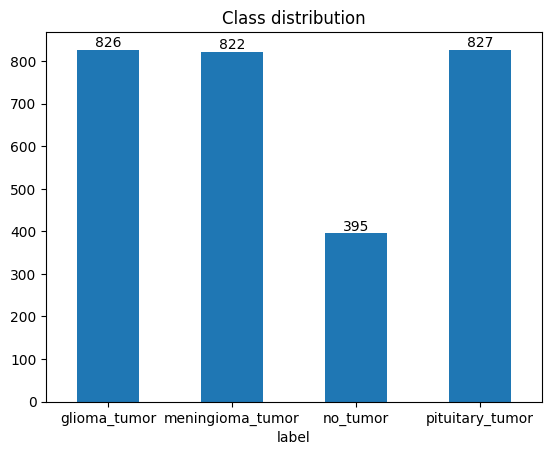

In [56]:
# Define a dictionary to map the integer labels to their corresponding class names
label_mapping = {
     0:'glioma_tumor',
     1: 'meningioma_tumor',
    2: 'no_tumor',
     3:'pituitary_tumor',
}

# Create a pandas DataFrame from the list of integer labels
df = pd.DataFrame({"label":y_labels})

# Map the integer labels to their corresponding class names in the DataFrame
df['label'] = df['label'].map(label_mapping)

# Create a bar plot of the class distribution
ax = df['label'].value_counts().sort_index().plot(kind='bar')

# Add text labels to the bars indicating the number of samples in each class
for i, count in enumerate(df['label'].value_counts().sort_index()):
    ax.text(i, count + 0.1, str(count), ha='center', va='bottom')

# Rotate the x-axis labels for readability
plt.xticks(rotation = 0)

# Add a title to the plot
plt.title('Class distribution')

# Display the plot
plt.show()

In [57]:

# Check if there are any corrupted images
if corrupted_images:
    # Print a message indicating that corrupted images were found
    print("Corrupted images found:")

    # Iterate through each corrupted image path
    for image_path in corrupted_images:
        # Print the path of the corrupted image
        print(image_path)
else:
    # Print a message indicating that no corrupted images were found
    print("No corrupted images found.")

No corrupted images found.


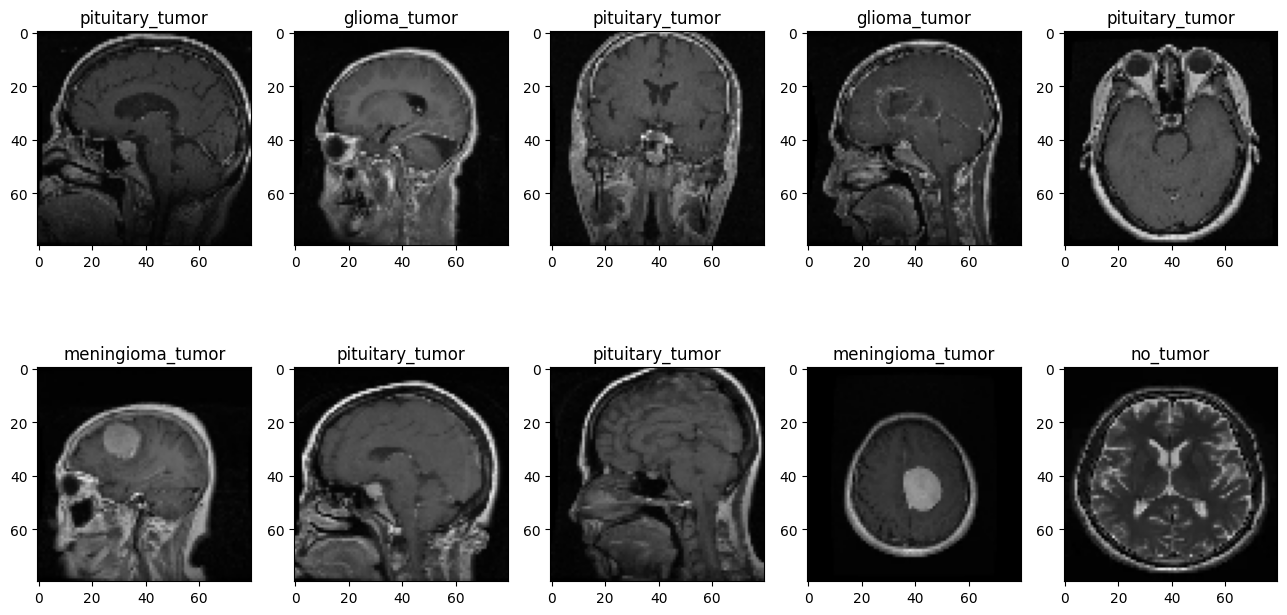

In [58]:
# Create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))

# Iterate through each subplot
for i in range(2):
    for j in range(5):
        # Check if there are any corrupted images
        if corrupted_images:
            # If there are corrupted images, display the next corrupted image in the subplot
            image_path = corrupted_images.pop(0)
            axes[i, j].imshow(plt.imread(image_path))
            axes[i, j].set_title("Corrupted Image")
        else:
            # If there are no corrupted images, display a random image from the dataset in the subplot
            idx = np.random.randint(len(X_data))
            axes[i, j].imshow(X_data[idx].astype(np.uint8))
            axes[i, j].set_title(class_names[y_labels[idx]])

# Display the figure
plt.show()

In [59]:
# Define the directory for each tumor dataset
giloma_tumor_directory = base_path+"/glioma_tumor"
no_tumor_directory =  base_path+"/no_tumor"
meningioma_tumor_directory = base_path + "/meningioma_tumor"
pituitary_tumor_directory =  base_path+"/pituitary_tumor"

In [60]:
# Load the image and convert it to an array
image_path = os.path.join(pituitary_tumor_directory,'p (2).jpg')
img = load_img(image_path)
x = img_to_array(img)

# Reshape the array to have a batch size of 1
x = x.reshape((1,) + x.shape)

# Print the shape of the reshaped array
print('shape of image', x.shape)

shape of image (1, 512, 512, 3)


In [61]:
datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                             rotation_range=10,fill_mode='nearest')

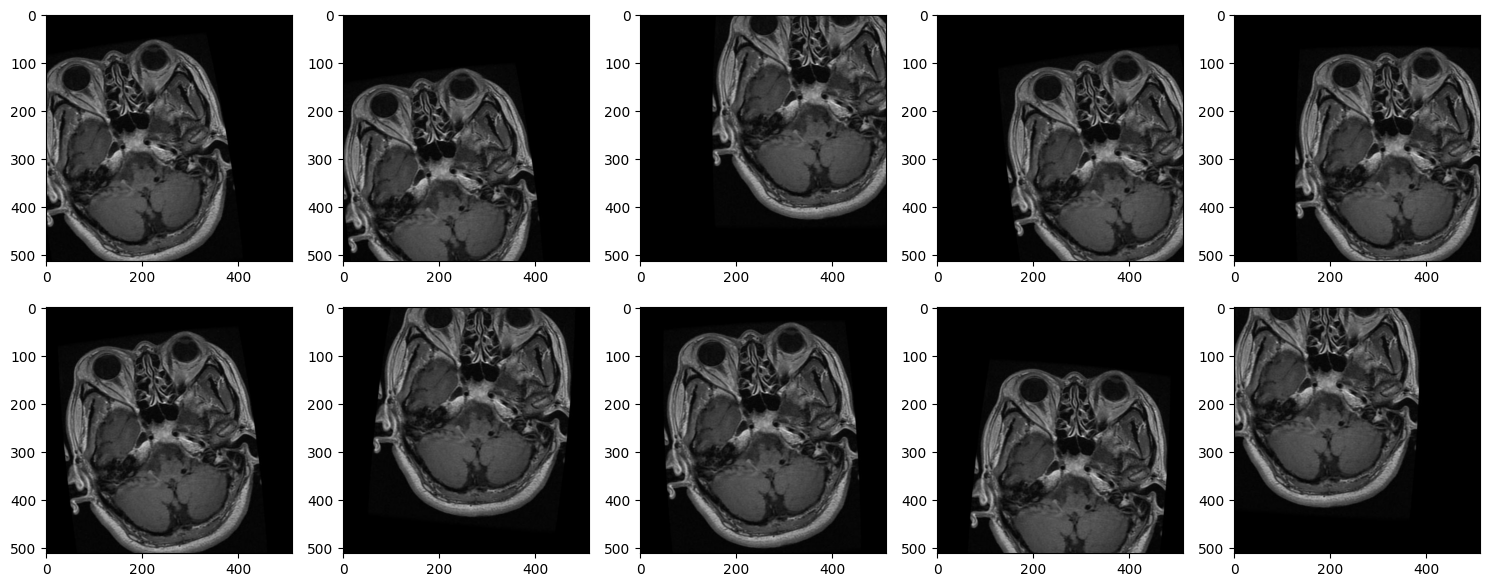

In [62]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, batch in enumerate(datagen.flow(x, batch_size=1)):
    if i >= 10:
        break
    row = i // 5
    col = i % 5
    img_to_show = (batch[0]).astype('uint8')
    axes[row][col].imshow(img_to_show)

plt.tight_layout()
plt.show()


In [63]:
# Initialize empty lists to store the image data and labels
image_data = []
image_labels = []

# Set the input dimension and image dimensions
input_dimension = 80
image_dimensions = (input_dimension, input_dimension)

# Loop over each class folder in the base path
for class_folder in os.listdir(base_path):


    class_folder_path = os.path.join(base_path, class_folder)
    for sub_folder in os.listdir(class_folder_path):
        sub_folder_path = os.path.join(class_folder_path, sub_folder)
        if os.path.isdir(sub_folder_path):
            for image_file in os.listdir(sub_folder_path):

                # Check if the image file has a .jpeg, .jpg, or .png extension
                if image_file.endswith((".jpeg", ".jpg", ".png")):

                    # Construct the image path
                    image_path = os.path.join(sub_folder_path, image_file)

                    # Read the image from the image path
                    image = cv2.imread(image_path)

                    # Resize the image to the specified image dimensions
                    image = cv2.resize(image, image_dimensions)
                    image_data.append(image)
                    image_labels.append(class_folder)
        else:

            # Check if the sub-folder path has a .jpeg, .jpg, or .png extension
            if sub_folder_path.endswith((".jpeg", ".jpg", ".png")):

                # Read the image from the sub-folder path
                image = cv2.imread(sub_folder_path)
                image = cv2.resize(image, image_dimensions)
                image_data.append(image)
                image_labels.append(class_folder)


In [64]:
image_data = np.array(image_data) / 255
image_labels = np.array(image_labels)
print(f'image_data shape:{image_data.shape}')
print(f'image_labels shape:{image_labels.shape}')

image_data shape:(2870, 80, 80, 3)
image_labels shape:(2870,)


In [65]:
# Load the image data and labels
imgs = image_data
labels = image_labels

# Set the number of augmentation rounds
augmentation_rounds = 40

# Define the image augmentation generator
augmentor = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                             rotation_range=10, fill_mode='nearest')


augmentor.fit(imgs)


augmented_images = []
augmented_labels = []

# Generate augmented images and labels using the augmentation generator
for image_batch, label_batch in augmentor.flow(imgs, labels, batch_size=32):
    augmented_images.append(image_batch)
    augmented_labels.append(label_batch)
    if len(augmented_images) >= augmentation_rounds:
        break

# Concatenate the original and augmented images and labels
images_data = np.concatenate((imgs, np.concatenate(augmented_images)))
labels = np.concatenate((labels, np.concatenate(augmented_labels)))

# Print the shapes of the combined images and labels
print(f"Combined images shape: {images_data.shape}")
print(f"Combined labels shape: {labels.shape}")

label_dataframe = pd.DataFrame({"label": labels})

# Print the label distribution
print("Label distribution:")
print(label_dataframe["label"].value_counts())

Combined images shape: (4150, 80, 80, 3)
Combined labels shape: (4150,)
Label distribution:
label
pituitary_tumor     1207
glioma_tumor        1190
meningioma_tumor    1179
no_tumor             574
Name: count, dtype: int64


In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images_data, labels, test_size=0.2, random_state=42)

In [67]:
# Print the shapes of the training images and labels
print(f'X_train shape:{X_train.shape}')
print(f'labels shape:{labels.shape}')

# Create a DataFrame to display the training label distribution
df = pd.DataFrame({"label":labels})
print(df.value_counts())
print("")

# Print the shapes of the test images and labels
print(f'test_date shape:{X_test.shape}')
print(f'test_labels shape:{y_test.shape}')

df = pd.DataFrame({"test_labels":y_test})

# Print the test label distribution
print(df.value_counts())

X_train shape:(3320, 80, 80, 3)
labels shape:(4150,)
label           
pituitary_tumor     1207
glioma_tumor        1190
meningioma_tumor    1179
no_tumor             574
Name: count, dtype: int64

test_date shape:(830, 80, 80, 3)
test_labels shape:(830,)
test_labels     
meningioma_tumor    251
pituitary_tumor     249
glioma_tumor        236
no_tumor             94
Name: count, dtype: int64


In [68]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

y_train_one_hot = to_categorical(y_train, num_classes=4)

y_test = le.fit_transform(y_test)
y_test_one_hot = to_categorical(y_test, num_classes=4)

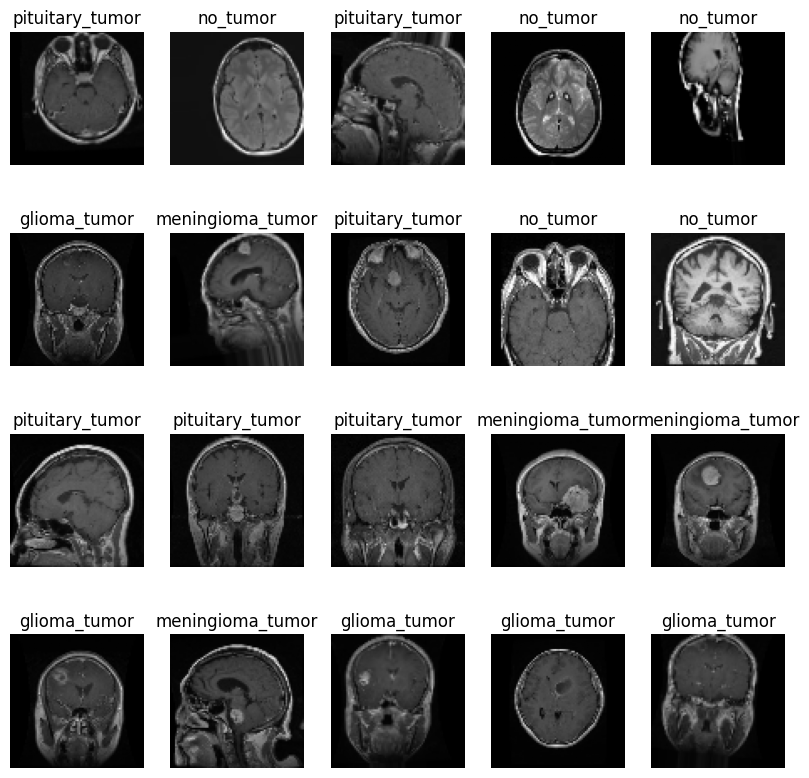

In [69]:
import matplotlib.pyplot as plt

data = images_data

# Select 20 random indices to use as a sample
indices = np.random.randint(0, len(data), 20)

sample_images = data[indices]

fig = plt.figure(figsize=(10,10))

# Loop over the sample images
for i, img in enumerate(sample_images):
    # Create a new subplot for each image
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(labels[indices[i]])

plt.show()

In [105]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define parameters
num_classes = 4
input_size = 80

# Set random seed
tf.random.set_seed(42)

# Define model
model_fcn = Sequential([
    #layers.Rescaling(1./255, input_shape=(input_size, input_size, 3)),
    Conv2D(32, (3, 3), activation='relu', input_shape=(input_size, input_size, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  # Output layer
])

In [106]:
model_fcn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_fcn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_291 (Conv2D)             │ (None, 78, 78, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 39, 39, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_292 (Conv2D)             │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_293 (Conv2D)             │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,152,420 (4.40 MB)

 Trainable params: 1,152,420 (4.40 MB)

 Non-trainable params: 0 (0.00 B)

In [107]:
epochs = 20
history_fcn= model_fcn.fit(
    X_train,
     y_train_one_hot,
    batch_size=32,
    epochs=epochs ,
    validation_split=0.2
)
model_fcn.save('model_fcn_full.h5')


Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.3720 - loss: 1.2780 - val_accuracy: 0.5979 - val_loss: 0.9259
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5655 - loss: 0.9842 - val_accuracy: 0.6220 - val_loss: 0.9059
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6740 - loss: 0.7758 - val_accuracy: 0.6792 - val_loss: 0.7811
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7340 - loss: 0.6613 - val_accuracy: 0.6958 - val_loss: 0.7224
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7430 - loss: 0.6126 - val_accuracy: 0.7334 - val_loss: 0.6703
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8057 - loss: 0.4850 - val_accuracy: 0.7470 - val_loss: 0.6630
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8467 - loss: 0.3851 - val_accuracy: 0.7425 - val_loss: 0.7495
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8796 - loss: 0.3288 - val_accuracy: 0.7575 - val

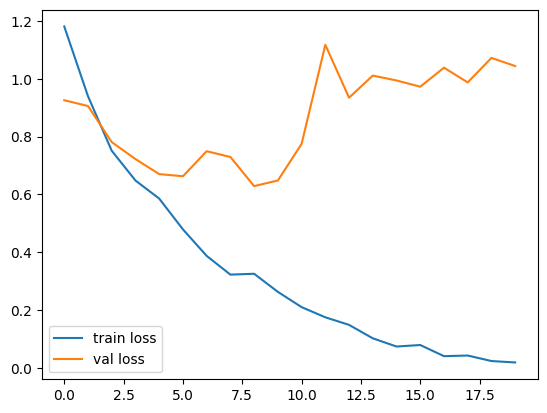

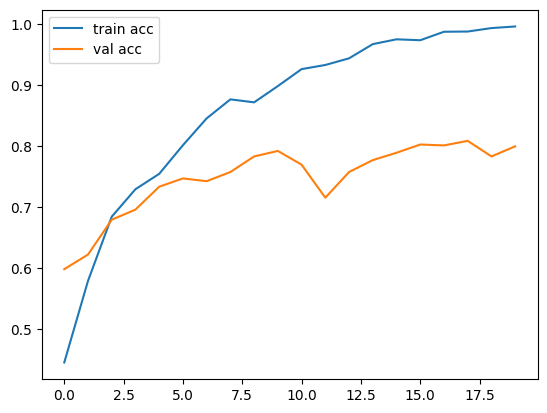

<Figure size 640x480 with 0 Axes>

In [108]:

# Plot the training and validation loss
plt.plot(history_fcn.history['loss'], label='train loss')
plt.plot(history_fcn.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# Plot the training and validation accuracy
plt.plot(history_fcn.history['accuracy'], label='train acc')
plt.plot(history_fcn.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [109]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Get predicted probabilities for test set
y_pred = model_fcn.predict(X_test)

# Get predicted classes by taking argmax of predicted probabilities
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_one_hot, axis=1)
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print("Accuracy:", accuracy)


print("Confusion matrix:")
confusion_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(confusion_matrix)

print("\nClassification report:")
print(classification_report(y_true_classes, y_pred_classes))

print("\nAccuracy score:", accuracy_score(y_true_classes, y_pred_classes))
print("F1 score:", f1_score(y_true_classes, y_pred_classes, average='weighted'))

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Accuracy: 0.8024096385542169
Confusion matrix:
[[217  16   0   3]
 [ 59 167  10  15]
 [  6   7  74   7]
 [ 20  18   3 208]]

Classification report:
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       236
           1       0.80      0.67      0.73       251
           2       0.85      0.79      0.82        94
           3       0.89      0.84      0.86       249

    accuracy                           0.80       830
   macro avg       0.82      0.80      0.80       830
weighted avg       0.81      0.80      0.80       830


Accuracy score: 0.8024096385542169
F1 score: 0.8009524157817074


<Axes: >

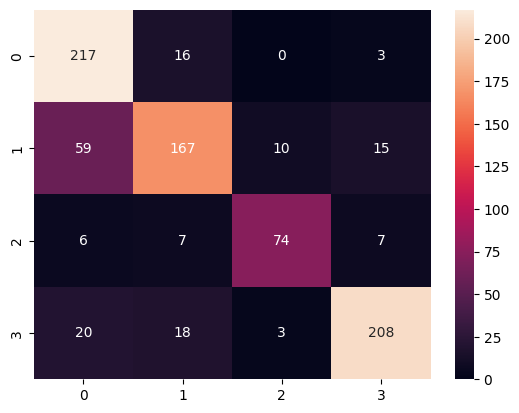

In [110]:
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True, fmt='d')

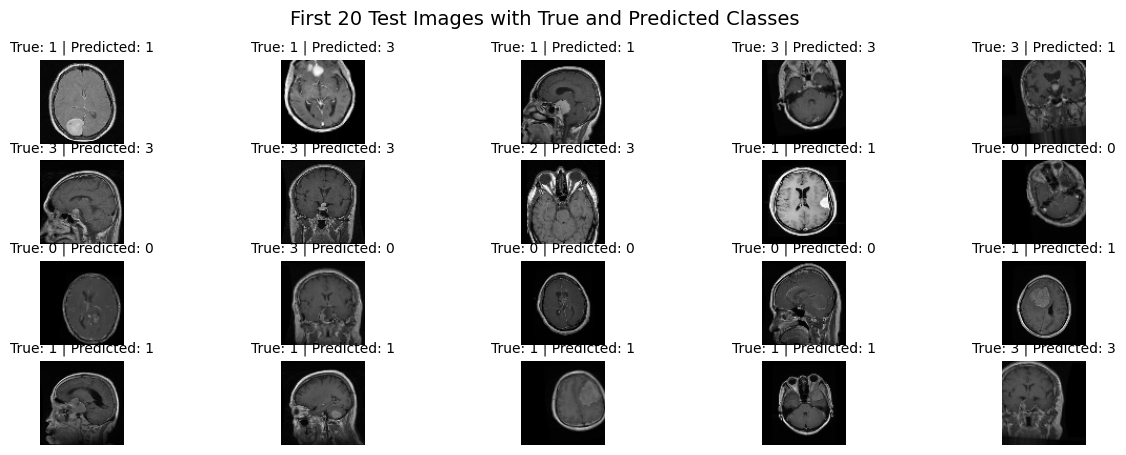

In [111]:

num_images = 20


plt.figure(figsize=(15, 5))
# Loop through the first num_images in the test set
for i in range(num_images):
    plt.subplot(4, 5, i + 1)
    plt.imshow((X_test[i] * 255).astype(np.uint8))
    plt.axis('off')

    # Create a title for the subplot with the true and predicted classes
    title = f"True: {y_true_classes[i]} | Predicted: {y_pred_classes[i]}"
    plt.title(title, fontsize=10)

plt.suptitle("First 20 Test Images with True and Predicted Classes", fontsize=14)
plt.show()

In [118]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Parameters
num_classes = 4
input_size = 80

# Set seed for reproducibility
tf.random.set_seed(42)

# Deeper model definition
model_deep = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(input_size, input_size, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Flatten and Dense layers
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])



In [119]:
## sgd compiler
model_deep.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_deep.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_306 (Conv2D)             │ (None, 80, 80, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_300         │ (None, 80, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_307 (Conv2D)             │ (None, 80, 80, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_301         │ (None, 80, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_308 (Conv2D)             │ (None, 40, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_302         │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_309 (Conv2D)             │ (None, 40, 40, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_303         │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_310 (Conv2D)             │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_304         │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_311 (Conv2D)             │ (None, 20, 20, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_305         │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │        32,89

 Total params: 3,599,268 (13.73 MB)

 Trainable params: 3,598,372 (13.73 MB)

 Non-trainable params: 896 (3.50 KB)

In [121]:
epochs = 25
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Updated model checkpoint to use new format
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history_cnn_deep = model_deep.fit(
    X_train, y_train_one_hot,
    epochs=epochs,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint]
)

# Save full model
model_deep.save('model_deep_full.keras')


Epoch 1/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4545 - loss: 1.8956 - val_accuracy: 0.2831 - val_loss: 3.0881
Epoch 2/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4939 - loss: 1.8017 - val_accuracy: 0.2831 - val_loss: 3.3343
Epoch 3/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5364 - loss: 1.7281 - val_accuracy: 0.2877 - val_loss: 3.3525
Epoch 4/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5828 - loss: 1.6342 - val_accuracy: 0.3027 - val_loss: 3.0261
Epoch 5/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5986 - loss: 1.5936 - val_accuracy: 0.3795 - val_loss: 2.5083
Epoch 6/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5950 - loss: 1.5806 - val_accuracy: 0.4533 - val_loss: 2.0841
Epoch 7/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6188 - loss: 1.5451 - val_accuracy: 0.5346 - val_loss: 1.9784
Epoch 8/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6364 - loss: 1.5046 - val_accuracy: 0.6145 - v

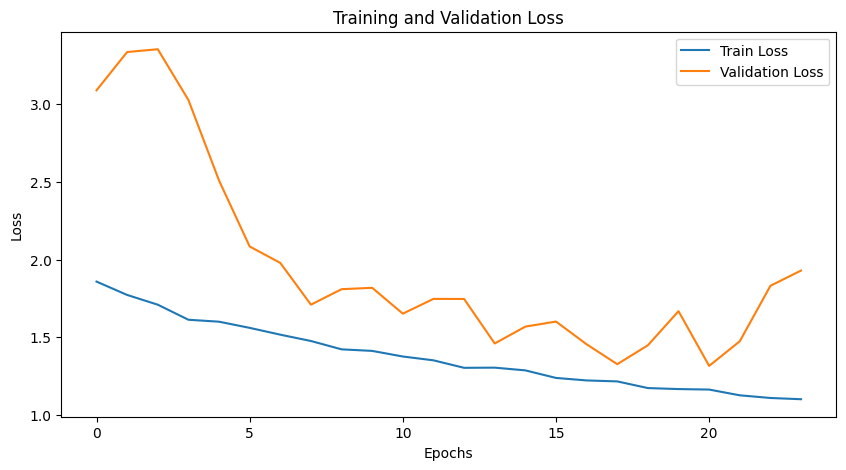

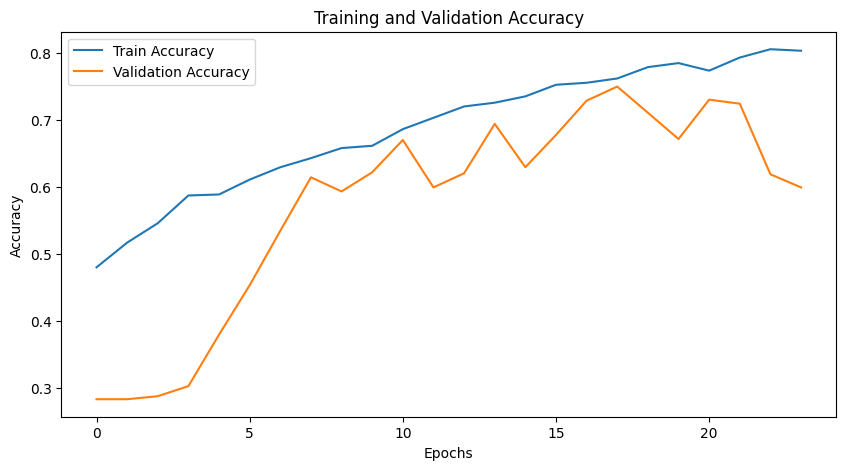

In [122]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history_cnn_deep.history['loss'], label='Train Loss')
plt.plot(history_cnn_deep.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('train_validation_loss.png')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_cnn_deep.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn_deep.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('train_validation_accuracy.png')
plt.show()


In [123]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Generate predictions for the test dataset
y_pred = model_deep.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_one_hot, axis=1)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print("Accuracy:", accuracy)

print("Confusion matrix:")
confusion_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(confusion_matrix)

print("\nClassification report:")
print(classification_report(y_true_classes, y_pred_classes))

# Print the accuracy and F1-score
print("\nAccuracy score:", accuracy_score(y_true_classes, y_pred_classes))
print("F1 score:", f1_score(y_true_classes, y_pred_classes, average='weighted'))

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Accuracy: 0.7373493975903614
Confusion matrix:
[[134  61   0  41]
 [  5 161  28  57]
 [  0  10  73  11]
 [  0   3   2 244]]

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.57      0.71       236
           1       0.69      0.64      0.66       251
           2       0.71      0.78      0.74        94
           3       0.69      0.98      0.81       249

    accuracy                           0.74       830
   macro avg       0.76      0.74      0.73       830
weighted avg       0.77      0.74      0.73       830


Accuracy score: 0.7373493975903614
F1 score: 0.7306914404276996


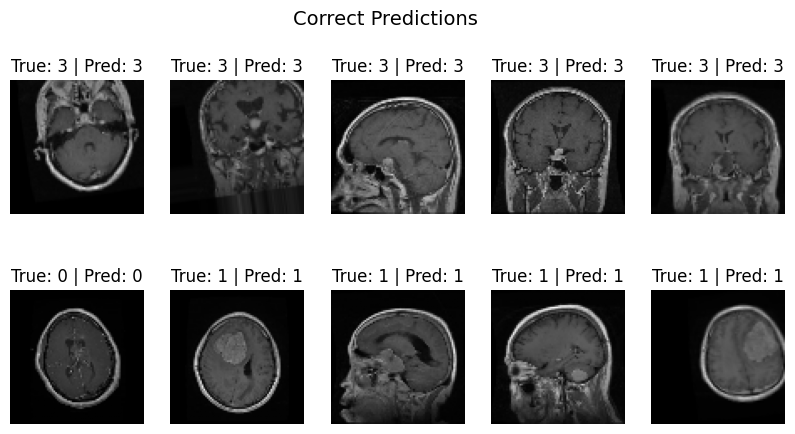

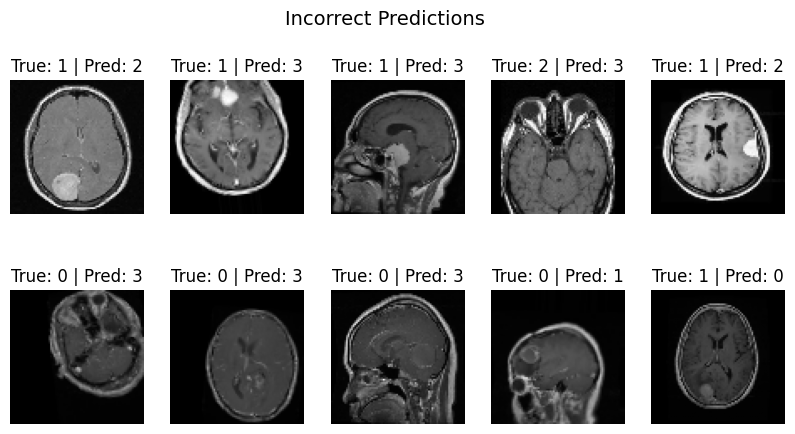

In [124]:
correct_indices = np.where(y_true_classes == y_pred_classes)[0]
incorrect_indices = np.where(y_true_classes != y_pred_classes)[0]

# Visualize correct predictions
plt.figure(figsize=(10, 5))
for i, idx in enumerate(correct_indices[:10]):  # Show 10 correct predictions
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx])
    plt.title(f"True: {y_true_classes[idx]} | Pred: {y_pred_classes[idx]}")
    plt.axis('off')
plt.suptitle("Correct Predictions", fontsize=14)
plt.show()

# Visualize incorrect predictions
plt.figure(figsize=(10, 5))
for i, idx in enumerate(incorrect_indices[:10]):  # Show 10 incorrect predictions
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx])
    plt.title(f"True: {y_true_classes[idx]} | Pred: {y_pred_classes[idx]}")
    plt.axis('off')
plt.suptitle("Incorrect Predictions", fontsize=14)
plt.show()


In [125]:
## adam compiler
model_deep.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_deep.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_306 (Conv2D)             │ (None, 80, 80, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_300         │ (None, 80, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_307 (Conv2D)             │ (None, 80, 80, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_301         │ (None, 80, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_308 (Conv2D)             │ (None, 40, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_302         │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_309 (Conv2D)             │ (None, 40, 40, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_303         │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_310 (Conv2D)             │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_304         │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_311 (Conv2D)             │ (None, 20, 20, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_305         │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │        32,89

 Total params: 3,599,268 (13.73 MB)

 Trainable params: 3,598,372 (13.73 MB)

 Non-trainable params: 896 (3.50 KB)

In [126]:
epochs = 25
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Model checkpoint to save the best weights only
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history_cnn_deep = model_deep.fit(
    X_train, y_train_one_hot,
    epochs=epochs,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint]
)

# Save the final full model
model_deep.save('model_deep_full_adam.keras')


Epoch 1/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.6109 - loss: 1.5492 - val_accuracy: 0.6220 - val_loss: 1.3220
Epoch 2/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6508 - loss: 1.3157 - val_accuracy: 0.2771 - val_loss: 2.8458
Epoch 3/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6906 - loss: 1.1646 - val_accuracy: 0.7274 - val_loss: 1.1674
Epoch 4/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6997 - loss: 1.1570 - val_accuracy: 0.5226 - val_loss: 1.8191
Epoch 5/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7574 - loss: 1.0162 - val_accuracy: 0.7319 - val_loss: 1.1053
Epoch 6/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7849 - loss: 0.9700 - val_accuracy: 0.7666 - val_loss: 0.9628
Epoch 7/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7816 - loss: 1.0194 - val_accuracy: 0.7967 - val_loss: 0.9272
Epoch 8/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8123 - loss: 0.8855 - val_accuracy: 0.8404 - 

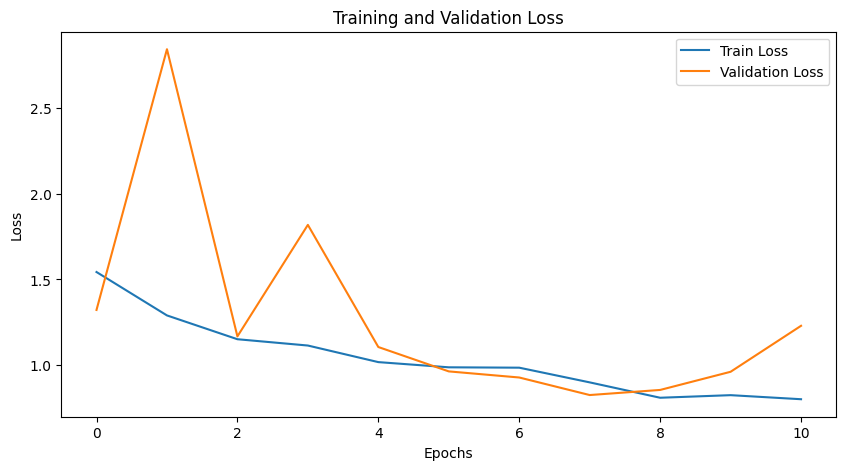

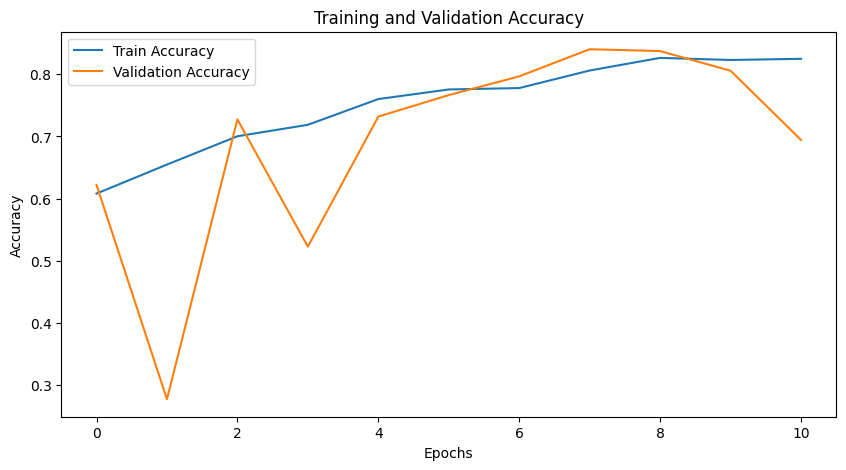

In [127]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history_cnn_deep.history['loss'], label='Train Loss')
plt.plot(history_cnn_deep.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('train_validation_loss.png')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_cnn_deep.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn_deep.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('train_validation_accuracy.png')
plt.show()

In [128]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Generate predictions for the test dataset
y_pred = model_deep.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_one_hot, axis=1)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print("Accuracy:", accuracy)

print("Confusion matrix:")
confusion_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(confusion_matrix)

print("\nClassification report:")
print(classification_report(y_true_classes, y_pred_classes))

# Print the accuracy and F1-score
print("\nAccuracy score:", accuracy_score(y_true_classes, y_pred_classes))
print("F1 score:", f1_score(y_true_classes, y_pred_classes, average='weighted'))

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Accuracy: 0.8397590361445784
Confusion matrix:
[[214  20   0   2]
 [ 33 165  34  19]
 [  1   4  84   5]
 [  4   8   3 234]]

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       236
           1       0.84      0.66      0.74       251
           2       0.69      0.89      0.78        94
           3       0.90      0.94      0.92       249

    accuracy                           0.84       830
   macro avg       0.82      0.85      0.83       830
weighted avg       0.84      0.84      0.84       830


Accuracy score: 0.8397590361445784
F1 score: 0.8364652864403526


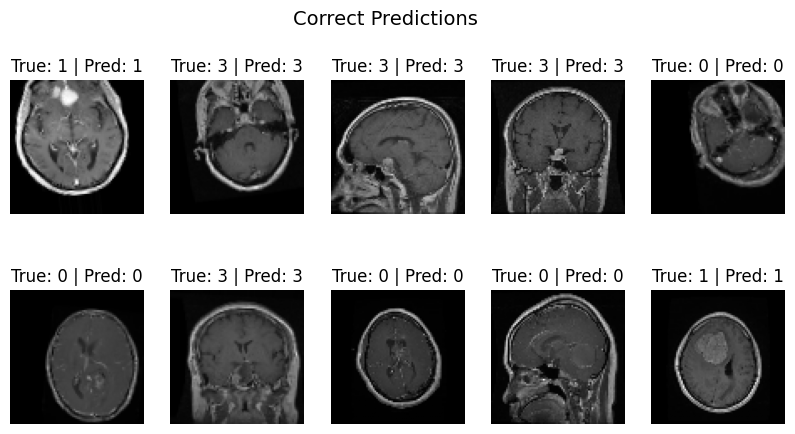

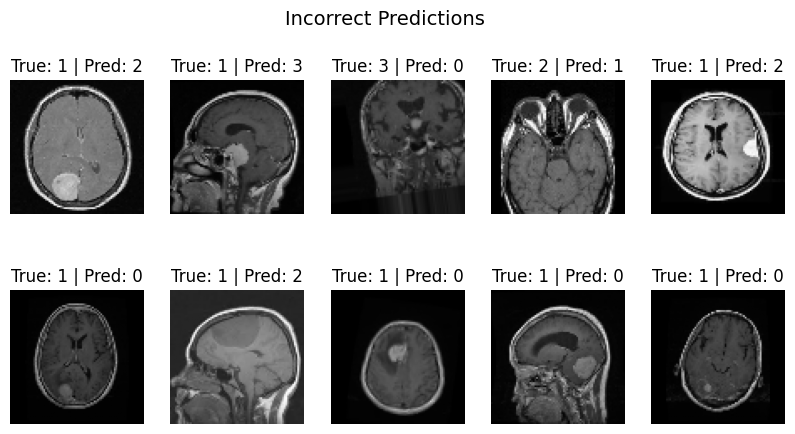

In [129]:
correct_indices = np.where(y_true_classes == y_pred_classes)[0]
incorrect_indices = np.where(y_true_classes != y_pred_classes)[0]

# Visualize correct predictions
plt.figure(figsize=(10, 5))
for i, idx in enumerate(correct_indices[:10]):  # Show 10 correct predictions
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx])
    plt.title(f"True: {y_true_classes[idx]} | Pred: {y_pred_classes[idx]}")
    plt.axis('off')
plt.suptitle("Correct Predictions", fontsize=14)
plt.show()

# Visualize incorrect predictions
plt.figure(figsize=(10, 5))
for i, idx in enumerate(incorrect_indices[:10]):  # Show 10 incorrect predictions
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx])
    plt.title(f"True: {y_true_classes[idx]} | Pred: {y_pred_classes[idx]}")
    plt.axis('off')
plt.suptitle("Incorrect Predictions", fontsize=14)
plt.show()

In [88]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

tf.random.set_seed(666)

# Match this to your actual input data shape
input_size = 80
input_shape = (input_size, input_size, 3)

# Load InceptionV3 base model
base_model = InceptionV3(include_top=False, input_shape=input_shape, weights='imagenet')

In [89]:

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(4, activation='softmax')(x)

# Create and compile the full model
transfer_learning_model = Model(inputs=base_model.input, outputs=x)
transfer_learning_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [90]:

# Train the model
history_Inception = transfer_learning_model.fit(
    X_train, y_train_one_hot,
    epochs=20,
    batch_size=32,
    validation_split=0.2
)

# Evaluate
loss, accuracy = transfer_learning_model.evaluate(X_test, y_test_one_hot, verbose=0)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 26s 172ms/step - accuracy: 0.5014 - loss: 1.2660 - val_accuracy: 0.6581 - val_loss: 0.8298
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7327 - loss: 0.6551 - val_accuracy: 0.6928 - val_loss: 0.7737
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7739 - loss: 0.5710 - val_accuracy: 0.7380 - val_loss: 0.6711
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8224 - loss: 0.4593 - val_accuracy: 0.7425 - val_loss: 0.6907
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8602 - loss: 0.3874 - val_accuracy: 0.7364 - val_loss: 0.7136
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9032 - loss: 0.2926 - val_accuracy: 0.7485 - val_loss: 0.6762
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9295 - loss: 0.2399 - val_accuracy: 0.7380 - val_loss: 0.7317
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9335 - loss: 0.2001 - val_accuracy: 0.7440 -

In [91]:

# Save model
transfer_learning_model.save('model_EfficientNet_full.h5')

In [93]:
# Predictions
y_pred = transfer_learning_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_one_hot, axis=1)

# Metrics
print("Confusion matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))

print("\nClassification report:")
print(classification_report(y_test_classes, y_pred_classes))

print("\nAccuracy score:", accuracy_score(y_test_classes, y_pred_classes))
print("F1 score:", f1_score(y_test_classes, y_pred_classes, average='weighted'))


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Confusion matrix:
[[162  57   4  13]
 [ 24 201  12  14]
 [  2  11  73   8]
 [  7  40   6 196]]

Classification report:
              precision    recall  f1-score   support

           0       0.83      0.69      0.75       236
           1       0.65      0.80      0.72       251
           2       0.77      0.78      0.77        94
           3       0.85      0.79      0.82       249

    accuracy                           0.76       830
   macro avg       0.77      0.76      0.76       830
weighted avg       0.77      0.76      0.76       830


Accuracy score: 0.7614457831325301
F1 score: 0.7633211714755757


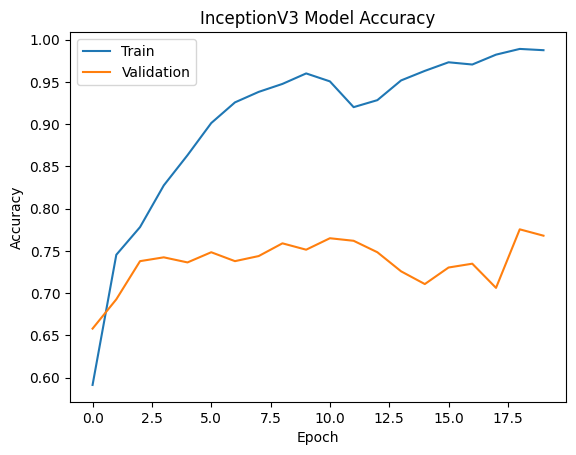

In [94]:

# Accuracy plot
plt.plot(history_Inception.history['accuracy'])
plt.plot(history_Inception.history['val_accuracy'])
plt.title('InceptionV3 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


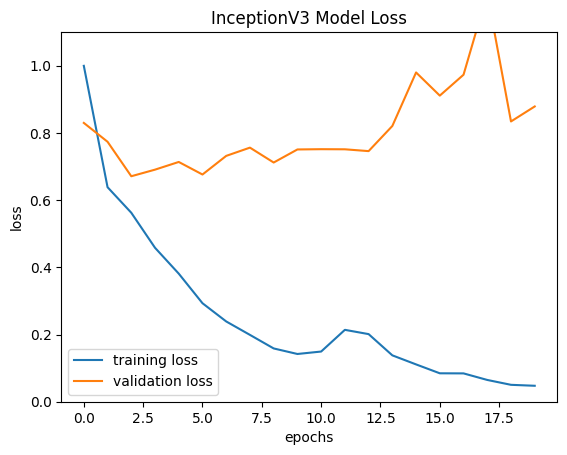

In [95]:
# Loss plot
plt.plot(history_Inception.history['loss'], label='training loss')
plt.plot(history_Inception.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.ylim(0,1.1)
plt.title('InceptionV3 Model Loss')
plt.show()

In [134]:
# Extract the validation accuracy of the last epoch for each model
val_acc_fcn = history_fcn.history['val_accuracy'][-1]
val_acc_cnn = history_cnn_deep.history['val_accuracy'][-1]
val_acc_Xception = history_Inception.history['val_accuracy'][-1]

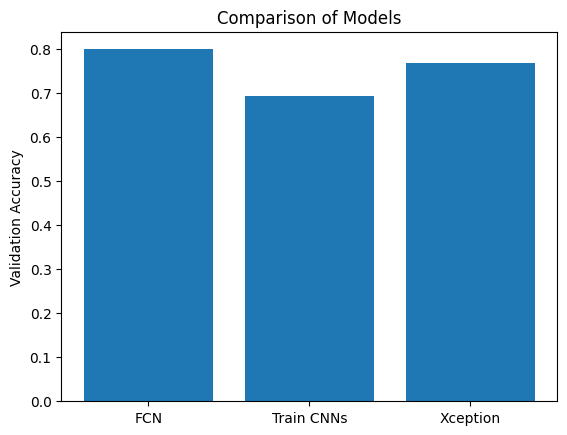

In [136]:
# Compare with other models
val_acc_Xception = history_Inception.history['val_accuracy'][-1]
models = ['FCN','Train CNNs', 'Xception']
val_accs = [val_acc_fcn, val_acc_cnn, val_acc_Xception]

fig, ax = plt.subplots()
ax.bar(models, val_accs)
ax.set_ylabel('Validation Accuracy')
ax.set_title('Comparison of Models')
plt.show()

Saving image(100).jpg to image(100).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted class: meningioma_tumor
Prediction probabilities: [2.5217474e-05 9.9605501e-01 3.7122599e-03 2.0750183e-04]


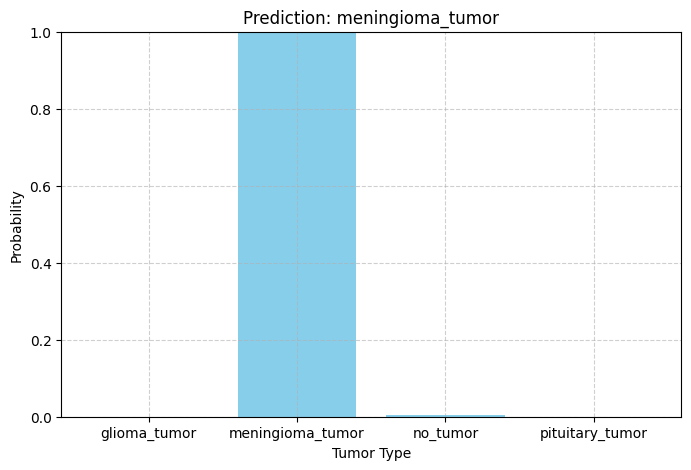

In [104]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import cv2

# Step 1: Upload Image
uploaded = files.upload()

# Step 2: Load and preprocess the image
img_path = list(uploaded.keys())[0]
img = load_img(img_path, target_size=(80, 80))  # Ensure this matches your model input
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = preprocess_input(img_array)  # Preprocess for InceptionV3

# Step 3: Predict
predictions = transfer_learning_model.predict(img_array)
predicted_class = np.argmax(predictions[0])
class_labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Step 4: Display prediction
print("Predicted class:", class_labels[predicted_class])
print("Prediction probabilities:", predictions[0])

# Step 5: Plot bar chart
plt.figure(figsize=(8,5))
plt.bar(class_labels, predictions[0], color='skyblue')
plt.xlabel('Tumor Type')
plt.ylabel('Probability')
plt.title(f'Prediction: {class_labels[predicted_class]}')
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
